# Stepik ML Contest (Conspect)
## Часть 1.
Практическим проектом нашего [курса](https://stepik.org/course/4852/syllabus) будет анализ активности студентов онлайн курса "Введение в анализ данных в R".

Описание данных:
- [events_train.csv](https://stepik.org/media/attachments/course/4852/event_data_train.zip) - данные о действиях, которые совершают студенты со стэпами.
    1. step_id - id стэпа
    2. user_id - анонимизированный id юзера
    3. timestamp - время наступления события в формате unix date
    4. action - событие, возможные значения: 
        - discovered - пользователь перешел на стэп
        - viewed - просмотр шага,
        - started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
        - passed - удачное решение практического шага. 
- [submissions_train.csv](https://stepik.org/media/attachments/course/4852/submissions_data_train.zip) - данные о времени и статусах сабмитов к практическим заданиям.
    1. step_id - id стэпа
    2. timestamp - время отправки решения в формате unix date
    3. submission_status - статус решения
    4. user_id - анонимизированный id юзера



Представим, что мы Дата-Аналитики в Степике и мы хотим предсказать/узнать, почему пользователи не заканчивают до конца курсы, что мы можем сделать, чтобы они заканчивали курсы и т.д.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Выгрузим данные, взглянем на них

In [3]:
events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip', compression ='zip')
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


Как мы можем заметить, данные выше не подходят для обучения каких-то моделей. Это сырые данные, которые не годятся для обучения и которые еще предстоит предобработать и подготовить для скармливания их модели.

При работе со временем очень часто используют формат timestamp ([Unix time](https://ru.wikipedia.org/wiki/Unix-%D0%B2%D1%80%D0%B5%D0%BC%D1%8F)). Привыкаем =)

В самую первую очередь, даже перед предобработкой и feature-инжиниринга, мы должны убедится в том, что данные, которые к нам пришли правильные, валидные, содержат в себе то, что должны и не содержат то, что не должны.

In [4]:
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [5]:
events_data.dtypes

step_id       int64
timestamp     int64
action       object
user_id       int64
dtype: object

Timestamp хоть и удобен в использовании в программировании, но он совсем неудобен для аналитики, группировки по дням, месяцам, исследования наших данных. Поэтому переведем наши данные в более наглядный вид.

In [6]:
events_data["date"] = pd.to_datetime(events_data.timestamp, unit="s")
events_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [7]:
events_data.date.min()

Timestamp('2015-06-15 04:00:48')

In [8]:
events_data.date.max()

Timestamp('2018-05-19 23:33:31')

Убеждаемся, что проблем со временем у нас нет. Данные, которые у нас есть содержат в себе информацию за 3 года и даты, которые здесь указаны, адекватны.

Создадим еще одну колонку для сохранения дня, в котором произошло то или иное событие.

In [9]:
events_data["day"] = events_data.date.dt.date
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


Теперь можем попробовать визуализировать эти данные, изучить, как изменялась динамика действий на курсе, и в целом увидеть, какая история таится за этим полотном данных.

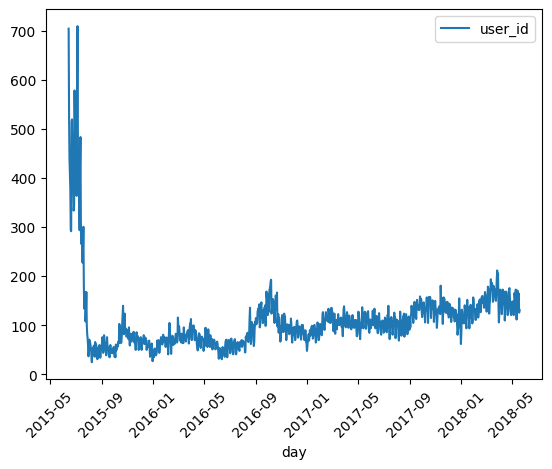

In [10]:
events_data\
    .groupby("day")\
    .agg({"user_id": "nunique"})\
    .plot().tick_params(axis='x', rotation=45)

Распределение пользователей по дням мы изучили, теперь рассмотрим распределение пользователей по количеству баллов, которые они набрали за курс.

In [11]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


Сначала рассмотрим НЕПРАВИЛЬНЫЙ способ посчитать количество набранных баллов у пользователей.

Только сперва взглянем на параметры исходного датасета.

In [12]:
events_data.shape

(3480703, 6)

In [19]:
events_data.user_id.nunique()

19234

In [14]:
events_data[events_data.action == "passed"]\
    .groupby("user_id", as_index=False)\
    .agg({"step_id": 'count'})\
    .rename(columns={"step_id": "passed_steps"})\
    .head()

,user_id,passed_steps
0,2,9
1,3,87
2,5,11
3,7,1
4,8,84


<Axes: >

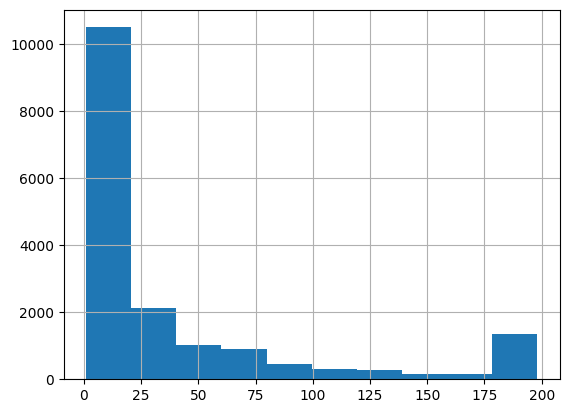

In [17]:
events_data[events_data.action == "passed"]\
    .groupby("user_id", as_index=False)\
    .agg({"step_id": 'count'})\
    .rename(columns={"step_id": "passed_steps"})\
    .passed_steps.hist()

Проблема такого подхода состоит в том, что пользователи, которые прошли 0 степов даже не попали в выборку, т.к. мы отфильтровали только те записи, которые содержат в себе пройденные степы, но пользователь мог и вовсе не пройти ни единого степа.

**НУЖНО СЛЕДИТЬ ЗА ВСЕМ ПРОИСХОДЯЩЕМ НА ЭТАПЕ ПРЕДОБРАБОТКИ, ЧТОБЫ НЕ ПОТЕРЯТЬ ДАННЫЕ.**

Постоянно себя валидируем. Проверяем, что число уников не изменилось. В данном случае мы должны проверить, что число уникальных пользователей не изменилось.

In [18]:
events_data[events_data.action == "passed"]\
    .groupby("user_id", as_index=False)\
    .agg({"step_id": 'count'})\
    .rename(columns={"step_id": "passed_steps"})\
    .user_id.nunique()

17262

Как мы можем заметить, оно изменилось. Уменьшилось на ~2 тысячи (когда выше мы насчитали 19234 уникальных пользователей). Т.е. мы просто взяли и отбросили 2 тысячи пользователей, чего делать нельзя, т.к. мы можем потерять очень много важной, повторюсь, ИСКЛЮЧИТЕЛЬНО ВАЖНОЙ информации. Может быть и так, что людей, которых мы отбросили, даже больше чем людей, которых мы оставили. 

За обработкой данных нужно следить крайне внимательно.

Теперь рассмотрим ПРАВИЛЬНЫЙ подход к подсчету пользователей и количества степов, которые они прошли.

Познакомимся с [pivot_table](https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html).

In [23]:
events_data.pivot_table(
    index="user_id",    # Строки новой таблицы
    columns="action",   # Колонки новой таблицы
    values="step_id",   # Переменная, со значениями которой мы будем делать аггрегацию
    aggfunc="count",    # Агрегационная функция
    fill_value=0        # Заполним NaN значения нулями
).head()

action,discovered,passed,started_attempt,viewed
user_id,,,,
1,1,0,0,1
2,9,9,2,10
3,91,87,30,192
5,11,11,4,12
7,1,1,0,1


Индексы достаточно сумбурно расположены, с ними неудобно работать, поэтому применим [reset_index](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html?highlight=reset_index#pandas.DataFrame.reset_index).

In [24]:
events_data.pivot_table(
    index="user_id",    # Строки новой таблицы
    columns="action",   # Колонки новой таблицы
    values="step_id",   # Переменная, со значениями которой мы будем делать аггрегацию
    aggfunc="count",    # Агрегационная функция
    fill_value=0        # Заполним NaN значения нулями
).reset_index().head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


Взглянем на более честное распределение уников:

<Axes: >

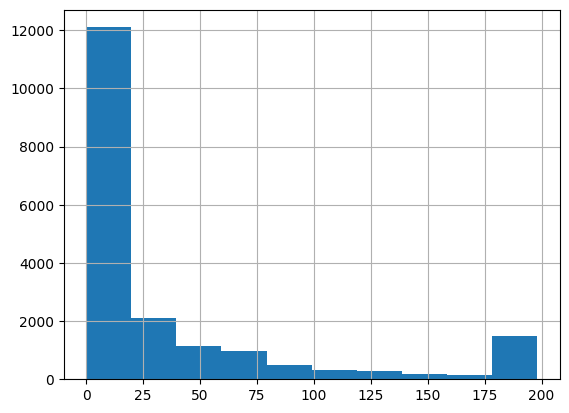

In [25]:
events_data.pivot_table(
    index="user_id",    # Строки новой таблицы
    columns="action",   # Колонки новой таблицы
    values="step_id",   # Переменная, со значениями которой мы будем делать аггрегацию
    aggfunc="count",    # Агрегационная функция
    fill_value=0        # Заполним NaN значения нулями
).reset_index().discovered.hist()